In [140]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [141]:
plt.style.use('seaborn-notebook')

In [142]:
import sys
# ADAPT FILE PATH TO GET FUNCTIONALITIES
sys.path.append("../../../../inbo_python-utilities/gbif/gbif_name_match")
sys.path.append("../../../../inbo_python-utilities/gbif/verify_synonyms/")
from gbif_species_name_match import (extract_species_information, 
                                     extract_gbif_species_names_info, 
                                     extract_gbif_accepted_key)
from verify_synonyms import verify_synonym

In [143]:
import asyncio
import aiohttp
import requests

# 1. Recorder unique scientific names derived from the nameserver

## Summary

In this section, the output of recorder unique names `recorder_sql_unique_names_output.csv` is matched with GBIF and the resulting matched file (with acceptedKeys for the derived SYNONYMS) is saved in the file `recorder_sql_unique_names_matched.csv`

## Data preparation

I extracted all unique species names from recorder (NBN-data) to make an overview of the species (for all surveys), using the query `recorder_sql_unique_names.sql`. After matching with GBIF, we can make a mapping in between 'recommended names' as defined by recorder and the accepted_keys from GBIF. If we manage to make this mapping, we can later on make an easy selection in both directions GBIF <-> Recorder.

First of all, extract the Recorder unique species names, by querying the NBN-database. for which the Query is stored in `SQL_unique_names.sql`:

In [144]:
recorder_names = pd.read_csv("../data/raw/recorder_sql_unique_names_output.csv", delimiter='\t', dtype=object)

In [145]:
recorder_names.head()

,RECOMMENDED_TAXON_VERSION_KEY,scientificName,TAXON_GROUP_NAME
0,NHMSYS0000456996,Caylusea,bloemplant
1,NHMSYS0000900079,Listrognathus mactator,insect - vliesvleugelige (Hymenoptera)
2,NBNSYS0100004462,Paratanytarsus dissimilis,insect - vlieg & mug (Diptera)
3,NHMSYS0000603228,Gymnodinium colymbeticum,wier
4,NHMSYS0000875969,Formicinae,insect - vliesvleugelige (Hymenoptera)


In [146]:
len(recorder_names)

144135

In [147]:
recorder_names[recorder_names['TAXON_GROUP_NAME'] == 'niet toegewezen']

,RECOMMENDED_TAXON_VERSION_KEY,scientificName,TAXON_GROUP_NAME
6467,NHMSYS0001697203,Prokaryota,niet toegewezen
10559,NHMSYS0000841310,Arthropoda,niet toegewezen
37772,INBSYS0000012542,Procyon lotor,niet toegewezen
38067,NHMSYS0000841034,Lepidoptera,niet toegewezen
42688,NBNSYS0000160353,Lycopodiopsida,niet toegewezen
65550,NHMSYS0000842161,Protista,niet toegewezen
70145,NBNSYS0000172125,Bryophyta,niet toegewezen
79432,NHMSYS0000841378,Pisces,niet toegewezen
92240,NHMSYS0000841351,Insecta,niet toegewezen
101203,NHMSYS0001747258,Lycopodiophyta,niet toegewezen


In [148]:
recorder_names['TAXON_GROUP_NAME'].unique()

array(['bloemplant', 'insect - vliesvleugelige (Hymenoptera)',
       'insect - vlieg & mug (Diptera)', 'wier', 'diatomee',
       'pseudoschorpioen (Pseudoscorpiones)', 'raderdiertje (Rotifera)',
       'springstaart (Collembola)', 'insect - kever (Coleoptera)',
       'levermos', 'foraminifeer', 'rondworm (Nematoda)', 'zwam',
       'lintworm (Cestoda)', 'ringworm', 'amfibie', 'mollusk (Mollusca)',
       'insect - nachtvlinder', 'bacterie', 'neteldier (=cnidarian)',
       'insect - vlo (Siphonaptera)', 'schaaldier', 'fungoide',
       'insect - trips (Thysanoptera)', 'buikhaarworm (Gastrotricha)',
       'insect - wants, cicade, bladluis (Hemiptera)', 'mijt (Acari)',
       'vogel', 'zuigworm (Trematoda)', 'beenvis (Actinopterygii)',
       'insect - dagvlinder', 'miljoenpoot', 'korstmos', 'spin (Araneae)',
       'mos', 'kraakbeenvis  (Chondrichthyes)', 'platworm (Turbellaria)',
       'varen', 'slurfworm (Kinorhyncha)', 'insect - haft (Ephemeroptera)',
       'ribkwal (Ctenophora

We introduce a mapping in between the INFORMAL GROUP defined by recorder and the kingdom we're dealing with:

In [149]:
mapping_kingdom = {'insect - kever (Coleoptera)' : 'Animalia',
                   'conifeer' : 'Plantae', 
                   'beenvis (Actinopterygii)' : 'Animalia', 
                   'vogel' : 'Animalia', 
                   'insect - nachtvlinder' : 'Animalia', 
                   'bloemplant' : 'Plantae',
                   'spin (Araneae)' : 'Animalia',
                   'insect - vlieg & mug (Diptera)' : 'Animalia', 
                   'diatomee' : 'Plantae',
                   'mollusk (Mollusca)' : 'Animalia',
                   'insect - dagvlinder' : 'Animalia', 
                   'insect - kokerjuffer (Trichoptera)' : 'Animalia',
                   'ringworm' : 'Animalia',
                   'mos' : 'Plantae',
                   'insect - wants, cicade, bladluis (Hemiptera)' : 'Animalia', 
                   'mijt (Acari)' : 'Animalia', 
                   'varen' : 'Plantae', 
                   'schaaldier' : 'Animalia', 
                   'landzoogdier' : 'Animalia', 
                   'kranswier' : 'Plantae',
                   'insect - sprinkhaan & krekel (Orthoptera)' : 'Animalia', 
                   'korstmos' : 'Plantae',
                   'platworm (Turbellaria)' : 'Animalia',
                   'insect - libel (Odonata)' : 'Animalia', 
                   'wier' : 'Plantae', 'paardenstaart' : 'Plantae',
                   'niet toegewezen': None, 
                   'levermos' : 'Plantae', 
                   'tweestaart (Diplura)' : 'Animalia',
                   'rondbek (Agnatha)' : 'Animalia', 
                   'duizendpoot' : 'Animalia', 
                   'wolfsklauw' : 'Plantae', 
                   'amfibie' : 'Animalia', 
                   'bacterie' : 'Bacteria',
                   'insect - nachtvlinder' : 'Animalia',
                   'reptiel' : 'Animalia',
                   'insect - vliesvleugelige (Hymenoptera)' : 'Animalia',
                   'zwam' : 'Fungi',
                   'kraakbeenvis  (Chondrichthyes)' : 'Animalia',
                   'rondworm (Nematoda)' : 'Animalia',
                   'virus' : 'Viruses',
                   'insect - steenvlieg (Plecoptera)' : 'Animalia',
                   'zeezoogdier' : 'Animalia',
                   'ginkgo' : 'Plantae',
                   'parasitaire nematode (Nematoda)' : 'Animalia',
                   'zuigworm (Trematoda)' : 'Animalia',
                   'biesvaren' : 'Plantae',
                   'neteldier (=cnidarian)' : 'Animalia',
                   'insect - trips (Thysanoptera)'  : 'Animalia',
                   'oerdiertje (Protozoa)' : 'Protozoa',
                   'hauwmos' : 'Plantae',
                   'lintworm (Cestoda)' : 'Animalia',
                   'manteldiertje (Urochordata)' : 'Animalia',
                   'stekelhuidige' : 'Animalia',
                   'ectoparasitaire platworm' : 'Animalia',
                   'ribkwal (Ctenophora)' : 'Animalia',
                   'mosdiertje (Bryozoa)' : 'Animalia',
                   'pseudoschorpioen (Pseudoscorpiones)' : 'Animalia',
                   'raderdiertje (Rotifera)' : 'Animalia',
                   'springstaart (Collembola)' : 'Animalia',
                   'foraminifeer' : 'Protozoa',
                   'insect - vlo (Siphonaptera)' : 'Animalia',
                   'fungoide' : 'Fungi', 
                   'buikhaarworm (Gastrotricha)' : 'Animalia',
                   'miljoenpoot' : 'Animalia',
                   'slurfworm (Kinorhyncha)' : 'Animalia',
                   'insect - haft (Ephemeroptera)' : 'Animalia',
                   'slijmzwam' : 'Protozoa',
                   'spons (Porifera)' : 'Animalia',
                   'slurfworm (Echiura)' : 'Animalia',
                   'zeespin (Pycnogonida)' : 'Animalia',
                   'spuitworm (Sipuncula)' : 'Animalia',
                   'insect - gaasvlieg (Neuroptera)' : 'Animalia',
                   'insect - houtluis (Psocoptera)' : 'Animalia',
                   'insect - waaiervleugelige (Strepsiptera)' : 'Animalia',
                   'kelkworm (Entoprocta)' : 'Animalia',
                   'beerdiertje (Tardigrada)' : 'Animalia',
                   'brachiopood (Brachiopoda)' : 'Animalia',
                   'baardworm (Pogonophora)' : 'Animalia',
                   'snoerworm (Nemertinea)' : 'Animalia',
                   'insect - oorworm (Dermaptera)' : 'Animalia',
                   'insect - luis (Phthiraptera)' : 'Animalia',
                   'kaakworm (Gnathostomulida)' : 'Animalia',
                   'pauropood' : 'Animalia',
                   'oerinsect (Protura)' : 'Animalia',
                   'loricifeer' : 'Animalia',
                   'insect - schorpioenvlieg (Mecoptera)' : 'Animalia',
                   'paardenhaarworm (Nematomorpha)' : 'Animalia',
                   'insect - kakkerlak (Dictyoptera)' : 'Animalia',
                   'priapulid' : 'Animalia',
                   'insect - zilvervis (Thysanura)' : 'Animalia',
                   'eikelworm (Hemichordata)' : 'Animalia',
                   'hooiwagen (Opiliones)' : 'Animalia',
                   'middendiertje (Mesozoa)' : 'Animalia',
                   'pijlworm (Chaetognatha)' : 'Animalia',
                   'insect - rotsspringer (Archaeognatha)' : 'Animalia',
                   'dwergpotige (Symphyla)' : 'Animalia',
                   'insect - kameelhalsvlieg (Raphidioptera)' : 'Animalia',
                   'hoefijzerworm (Phoronida)' : 'Animalia',
                   'insect - wandelende tak (Phasmida)' : 'Animalia',
                   'lipklever (Cycliophora)' : 'Animalia',
                   'insect - elzenvlieg (Megaloptera)' : 'Animalia',
                   'schorpioen' : 'Animalia',
                   'insect - bidsprinkhaan (Mantodea)' : 'Animalia',
                   'ongedetermineerd' : None,
                   np.nan : None
                    }

In [150]:
recorder_names['kingdom'] = recorder_names['TAXON_GROUP_NAME'].replace(mapping_kingdom)

In [151]:
recorder_names["kingdom"].unique()

array(['Plantae', 'Animalia', 'Protozoa', 'Fungi', 'Bacteria', None,
       'Viruses'], dtype=object)

In [152]:
len(recorder_names)

144135

In [153]:
recorder_names.head()

,RECOMMENDED_TAXON_VERSION_KEY,scientificName,TAXON_GROUP_NAME,kingdom
0,NHMSYS0000456996,Caylusea,bloemplant,Plantae
1,NHMSYS0000900079,Listrognathus mactator,insect - vliesvleugelige (Hymenoptera),Animalia
2,NBNSYS0100004462,Paratanytarsus dissimilis,insect - vlieg & mug (Diptera),Animalia
3,NHMSYS0000603228,Gymnodinium colymbeticum,wier,Plantae
4,NHMSYS0000875969,Formicinae,insect - vliesvleugelige (Hymenoptera),Animalia


## Asynchronuous performing the requests

As we went to request 144135 different names to the GBIF backbone, a asyncronious requesting should be possible in order to shorten the time to retrieve the results:

### Minimal working example

The concept of an asyncronious request of the API as example:

In [154]:
class Collector():
    def __init__(self):
        self.data = {}

    async def fetch(self, session, name, kingdom, idx):
        parameters = {'verbose': False, 'strict': True, 'name' : name, 'kingdom': kingdom}
        async with client.get('http://api.gbif.org/v1/species/match', params=parameters) as resp:
            if resp.status != 200:
                print(await resp.reason)
            else:
                #print(await resp.json())
                self.data[idx] = await resp.json()

In [155]:
testcase = recorder_names.iloc[:100,:]

In [156]:
names = testcase["scientificName"].values.tolist()
kingdoms = testcase["kingdom"].values.tolist()
inbo_idx = testcase["RECOMMENDED_TAXON_VERSION_KEY"].values.tolist()

In [157]:
test = Collector()
with aiohttp.ClientSession() as client:
    asyncio.get_event_loop().run_until_complete(asyncio.gather(
            *[test.fetch(client, name, kingdom, idx) for name, kingdom, idx in zip(names, kingdoms, inbo_idx)], 
            return_exceptions=True))

In [158]:
len(test.data)

100

Just a single example:

In [159]:
test.data['BMSSYS0000002618']

{'canonicalName': 'Bolbitius conocephalus',
 'class': 'Agaricomycetes',
 'classKey': 186,
 'confidence': 100,
 'family': 'Bolbitiaceae',
 'familyKey': 8440,
 'genus': 'Galerella',
 'genusKey': 8617918,
 'kingdom': 'Fungi',
 'kingdomKey': 5,
 'matchType': 'EXACT',
 'order': 'Agaricales',
 'orderKey': 1499,
 'phylum': 'Basidiomycota',
 'phylumKey': 34,
 'rank': 'SPECIES',
 'scientificName': 'Bolbitius conocephalus (Bull.) Fr., 1874',
 'species': 'Galerella conocephala',
 'speciesKey': 5449507,
 'status': 'SYNONYM',
 'synonym': True,
 'usageKey': 2529985}

### Chunked version execution

Let's try it in chunks of around 100 requests in batches of 50000:

In [160]:
len(recorder_names)

144135

In [161]:
import time

I made the following cells in raw-text to exclude them from running the whole sequence again when just running the notebook, the result of the sequence of runs is loaded as a variable: `recorder_matched` in the next code cell

Not missing that much requests anymore, since we're less than 144135 requests

### Retrying the missing requests 

Some requests just went wrong, let's redo this set of around 100 failures..

Reading in the matches names from the last performed matching

### getting the acceptedKey when the status is not accepted but SYNONYM

## Checking the matched result

In [162]:
recorder_matched = pd.read_csv("../data/interim/recorder_sql_unique_names_matched.csv", dtype=object)

In [163]:
recorder_matched = recorder_matched.rename(columns={"Unnamed: 0.1": "INBO_identifier"})

In [164]:
recorder_matched.head()

,INBO_identifier,canonicalName,class,classKey,confidence,family,familyKey,genus,genusKey,kingdom,...,phylumKey,rank,scientificName,species,speciesKey,status,synonym,usageKey,acceptedKey,acceptedScientificName
0,INBSYS0000005533,Cotoneaster villosulus,Magnoliopsida,220,100,Rosaceae,5015,Cotoneaster,3025563,Plantae,...,7707728,SPECIES,Cotoneaster villosulus (Rehder & E.H. Wilson) ...,Cotoneaster acutifolius,3025770,SYNONYM,True,3025564,3025565,Cotoneaster acutifolius var. villosulus Rehd. ...
1,NBNSYS0000019326,NaN,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
2,NBNSYS0000022430,Leuctra hippopus,Insecta,216,100,Leuctridae,2998,Leuctra,2001760,Animalia,...,54,SPECIES,"Leuctra hippopus Kempny, 1899",Leuctra hippopus,2001976,ACCEPTED,False,2001976,2001976,"Leuctra hippopus Kempny, 1899"
3,NBNSYS0200001885,Axonopus compressus,Liliopsida,196,100,Poaceae,3073,Mesosetum,4113460,Plantae,...,7707728,SPECIES,Axonopus compressus (Sw.) P.Beauv.,Mesosetum compressum,4114391,SYNONYM,True,2705924,4114391,Mesosetum compressum Swallen
4,NHMSYS0001480349,Dasyscyphus relicinus,Leotiomycetes,179,100,Lachnaceae,3295205,Lachnum,2581043,Fungi,...,95,SPECIES,Dasyscyphus relicinus (Fr.) Boud.,Lachnum relicinum,3489190,SYNONYM,True,3281874,3489190,"Lachnum relicinum (Fr.) P. Karst., 1871"


Some summary information:

In [165]:
recorder_matched.columns

Index(['INBO_identifier', 'canonicalName', 'class', 'classKey', 'confidence',
       'family', 'familyKey', 'genus', 'genusKey', 'kingdom', 'kingdomKey',
       'matchType', 'note', 'order', 'orderKey', 'phylum', 'phylumKey', 'rank',
       'scientificName', 'species', 'speciesKey', 'status', 'synonym',
       'usageKey', 'acceptedKey', 'acceptedScientificName'],
      dtype='object')

In [166]:
recorder_matched["matchType"].count()

144135

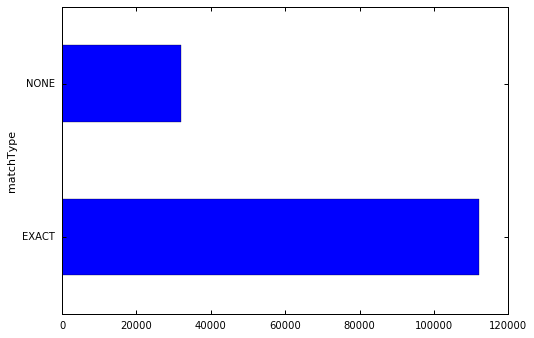

In [167]:
recorder_matched.groupby(("matchType")).count()["confidence"].plot(kind="barh")

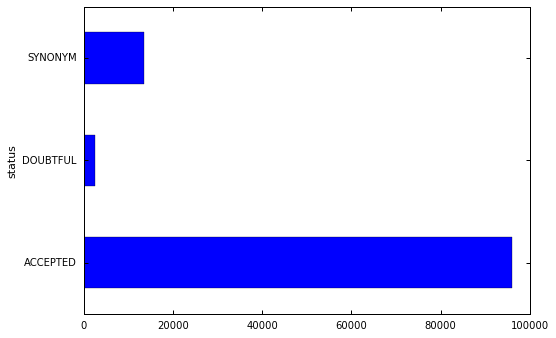

In [168]:
recorder_matched.groupby(("status")).count()["canonicalName"].plot(kind="barh")

Other 39000 are NONE...

#### Different reasons for failed answer in the note:

*Multiple equal matches for...* added by the name

In [169]:
sum(recorder_matched["note"].str.contains("too little").dropna())

19818

*No match because of too little confidence*

In [170]:
sum(recorder_matched["note"].str.contains("Multiple equal matches").dropna())

988

*N synonym homonyms* (with N = 2, 3,...) -> When SYNONYM is found

In [171]:
sum(recorder_matched["note"].str.contains("synonym homonyms").dropna())

1344

In [172]:
recorder_matched.columns

Index(['INBO_identifier', 'canonicalName', 'class', 'classKey', 'confidence',
       'family', 'familyKey', 'genus', 'genusKey', 'kingdom', 'kingdomKey',
       'matchType', 'note', 'order', 'orderKey', 'phylum', 'phylumKey', 'rank',
       'scientificName', 'species', 'speciesKey', 'status', 'synonym',
       'usageKey', 'acceptedKey', 'acceptedScientificName'],
      dtype='object')

In [173]:
recorder_matched.head()

,INBO_identifier,canonicalName,class,classKey,confidence,family,familyKey,genus,genusKey,kingdom,...,phylumKey,rank,scientificName,species,speciesKey,status,synonym,usageKey,acceptedKey,acceptedScientificName
0,INBSYS0000005533,Cotoneaster villosulus,Magnoliopsida,220,100,Rosaceae,5015,Cotoneaster,3025563,Plantae,...,7707728,SPECIES,Cotoneaster villosulus (Rehder & E.H. Wilson) ...,Cotoneaster acutifolius,3025770,SYNONYM,True,3025564,3025565,Cotoneaster acutifolius var. villosulus Rehd. ...
1,NBNSYS0000019326,NaN,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
2,NBNSYS0000022430,Leuctra hippopus,Insecta,216,100,Leuctridae,2998,Leuctra,2001760,Animalia,...,54,SPECIES,"Leuctra hippopus Kempny, 1899",Leuctra hippopus,2001976,ACCEPTED,False,2001976,2001976,"Leuctra hippopus Kempny, 1899"
3,NBNSYS0200001885,Axonopus compressus,Liliopsida,196,100,Poaceae,3073,Mesosetum,4113460,Plantae,...,7707728,SPECIES,Axonopus compressus (Sw.) P.Beauv.,Mesosetum compressum,4114391,SYNONYM,True,2705924,4114391,Mesosetum compressum Swallen
4,NHMSYS0001480349,Dasyscyphus relicinus,Leotiomycetes,179,100,Lachnaceae,3295205,Lachnum,2581043,Fungi,...,95,SPECIES,Dasyscyphus relicinus (Fr.) Boud.,Lachnum relicinum,3489190,SYNONYM,True,3281874,3489190,"Lachnum relicinum (Fr.) P. Karst., 1871"


# 2. Verify the SYNONYM with a list of known verifications

The workflow is comparable to the one described on [https://github.com/inbo/invasive-t0-occurrences/issues/52](https://github.com/inbo/invasive-t0-occurrences/issues/52), in order to derive an overview of the verified matching of the nameserver towards the GBIF services

In [174]:
recorder_matched["nameMatchValidation"] = np.nan

In [176]:
recorder_matched.loc[recorder_matched["status"] == "ACCEPTED", "nameMatchValidation"] = 'ok'
recorder_matched.loc[recorder_matched["status"] == "DOUBTFUL", "nameMatchValidation"] = 'ok: DOUBTFUL'

Running the verification of the synonyms

In [177]:
recorder_matched.columns

Index(['INBO_identifier', 'canonicalName', 'class', 'classKey', 'confidence',
       'family', 'familyKey', 'genus', 'genusKey', 'kingdom', 'kingdomKey',
       'matchType', 'note', 'order', 'orderKey', 'phylum', 'phylumKey', 'rank',
       'scientificName', 'species', 'speciesKey', 'status', 'synonym',
       'usageKey', 'acceptedKey', 'acceptedScientificName',
       'nameMatchValidation'],
      dtype='object')

In [178]:
recorder_matched = recorder_matched.rename(columns={"status": "gbif_status"})

In [179]:
recorder_matched = verify_synonym(recorder_matched, "temp_out.tsv", 
                                  "https://raw.githubusercontent.com/inbo/alien-species-checklist/master/data/vocabularies/verified-synonyms.tsv", 
                                  usagekeycol='usageKey', 
                                  acceptedkeycol='acceptedKey', 
                                  taxonomicstatuscol='gbif_status', 
                                  outputcol='nameMatchValidation')

Number of corrections initiated by the synonym verification:

In [180]:
temp = recorder_matched[(recorder_matched["nameMatchValidation"].notnull()) & 
                 (recorder_matched["nameMatchValidation"].str.contains("ok:"))
                ]
len(temp[~temp["nameMatchValidation"].str.contains("ok: DOUBTFUL")])


120

remove redundant columns:

In [185]:
recorder_matched = recorder_matched.drop(["gbifapi_usageKey", "gbifapi_acceptedKey"], axis=1)

# 3. Data product

For the final data product, we want to provide the matches we can trust, i.e. the status is `ACCEPTED`, `DOUBTFUL` or a verified `SYNONYM`

In [186]:
recorder_matched_verified = recorder_matched[recorder_matched['nameMatchValidation'].notnull & recorder_matched['nameMatchValidation'].str.contains('^ok', regex=True)]

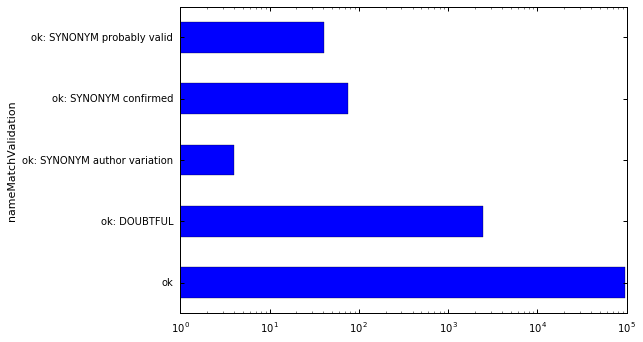

In [187]:
recorder_matched_verified.groupby(('nameMatchValidation')).count()['INBO_identifier'].plot(kind="barh", logx=True)

In [189]:
recorder_matched_verified.to_csv('../data/processed/recorder_sql_unique_names_matched_verified.tsv',
                                 index=False, sep='\t', na_rep="")

# 4. THIS NEED TO GO TO OTHER DATA REPO

##  Species list to report on defined by Tim/Sander

**Need to be adjusted from here, as defined in [ISSUE #47](https://github.com/inbo/invasive-t0-occurrences/issues/47):**

Read species list:

In [343]:
invasive_species = pd.read_csv("../../species-list/species-list.tsv", delimiter="\t", dtype=object)

In [344]:
len(invasive_species)

152

In [357]:
invasive_species.head()

,index,name,kingdom,euConcernStatus,gbifapi_usageKey,gbifapi_scientificName,gbifapi_canonicalName,gbifapi_status,gbifapi_rank,gbifapi_matchType,gbifapi_confidence,gbifapi_acceptedKey,gbifapi_acceptedScientificName,nbnTaxonID
0,0,Acer negundo,Plantae,under consideration,3189866,Acer negundo L.,Acer negundo,ACCEPTED,SPECIES,EXACT,100,3189866,Acer negundo L.,NBNSYS0000014604
1,1,Alopochen aegyptiaca,Animalia,under consideration,2498252,"Alopochen aegyptiaca (Linnaeus, 1766)",Alopochen aegyptiaca,ACCEPTED,SPECIES,EXACT,100,2498252,"Alopochen aegyptiaca (Linnaeus, 1766)",NHMSYS0001689380
2,2,Alternanthera philoxeroides,Plantae,under consideration,3084923,Alternanthera philoxeroides (Mart.) Griseb.,Alternanthera philoxeroides,ACCEPTED,SPECIES,EXACT,100,3084923,Alternanthera philoxeroides (Mart.) Griseb.,NaN
3,3,Ameiurus melas,Animalia,under consideration,2340977,"Ameiurus melas (Rafinesque, 1820)",Ameiurus melas,ACCEPTED,SPECIES,EXACT,100,2340977,"Ameiurus melas (Rafinesque, 1820)",NHMSYS0000544615
4,4,Asclepias syriaca,Plantae,under consideration,3170247,Asclepias syriaca L.,Asclepias syriaca,ACCEPTED,SPECIES,EXACT,99,3170247,Asclepias syriaca L.,INBSYS0000005932


In [358]:
recorder_matched.columns

Index(['NBN_index', 'canonicalName', 'class', 'classKey', 'confidence',
       'family', 'familyKey', 'genus', 'genusKey', 'kingdom', 'kingdomKey',
       'matchType', 'note', 'order', 'orderKey', 'phylum', 'phylumKey', 'rank',
       'scientificName', 'species', 'speciesKey', 'status', 'synonym',
       'usageKey', 'acceptedKey', 'acceptedScientificName'],
      dtype='object')

In [359]:
invasive_species_key = invasive_species[['name', 'kingdom', 
                                         'gbifapi_acceptedKey', 
                                         'gbifapi_acceptedScientificName']]

In [360]:
recorder_matched_key = recorder_matched[~recorder_matched["acceptedKey"].isnull()][['NBN_index', 
                                                                                    'acceptedKey', 
                                                                                    'status', 
                                                                                    'confidence']]

In [368]:
combination = pd.merge(invasive_species_key, 
                recorder_matched_key, 
                how='left',
                left_on="gbifapi_acceptedKey", 
                right_on="acceptedKey",
                suffixes=('_species', '_recorder'))

In [369]:
combination

,name,kingdom,gbifapi_acceptedKey,gbifapi_acceptedScientificName,NBN_index,acceptedKey,status,confidence
0,Acer negundo,Plantae,3189866,Acer negundo L.,NBNSYS0000014604,3189866,ACCEPTED,100
1,Alopochen aegyptiaca,Animalia,2498252,"Alopochen aegyptiaca (Linnaeus, 1766)",NHMSYS0001689380,2498252,SYNONYM,100
2,Alternanthera philoxeroides,Plantae,3084923,Alternanthera philoxeroides (Mart.) Griseb.,NaN,NaN,NaN,NaN
3,Ameiurus melas,Animalia,2340977,"Ameiurus melas (Rafinesque, 1820)",NHMSYS0000544615,2340977,ACCEPTED,100
4,Asclepias syriaca,Plantae,3170247,Asclepias syriaca L.,INBSYS0000005932,3170247,ACCEPTED,99
5,Symphyotrichum salignum,Plantae,3151811,Symphyotrichum salignum (Willd.) G.L.Nesom,NaN,NaN,NaN,NaN
6,Baccharis halimifolia,Plantae,NaN,NaN,NaN,NaN,NaN,NaN
7,Bison bison,Animalia,2441176,"Bison bison (Linnaeus, 1758)",NaN,NaN,NaN,NaN
8,Cabomba caroliniana,Plantae,2882443,Cabomba caroliniana A. Gray,NHMSYS0000456744,2882443,ACCEPTED,100
9,Callosciurus erythraeus,Animalia,2437394,"Callosciurus erythraeus (Pallas, 1779)",INBSYS0000012711,2437394,ACCEPTED,100


In [370]:
species_info_recorder_matches = pd.merge(combination, recorder_names, how='left', left_on="NBN_index", 
                                         right_on="RECOMMENDED_TAXON_VERSION_KEY",
                                         suffixes=('_x', '_recorder'))

In [371]:
species_info_recorder_matches = species_info_recorder_matches.drop(["RECOMMENDED_TAXON_VERSION_KEY", 
                                                                    "acceptedKey", "kingdom_recorder"],axis=1)

In [372]:
species_info_recorder_matches = species_info_recorder_matches.rename(columns={"kingdom_x":"kingdom", 
                                              "status":"NBN_status",
                                              "confidence":"NBN_confidence",
                                              "scientificName":"NBN_scientificName",
                                              "TAXON_GROUP_NAME":"NBN_taxon_group_info"
                                             })

In [373]:
species_info_recorder_matches.dtypes

name                              object
kingdom                           object
gbifapi_acceptedKey               object
gbifapi_acceptedScientificName    object
NBN_index                         object
NBN_status                        object
NBN_confidence                    object
NBN_scientificName                object
NBN_taxon_group_info              object
dtype: object

In [376]:
species_info_recorder_matches

,name,kingdom,gbifapi_acceptedKey,gbifapi_acceptedScientificName,NBN_index,NBN_status,NBN_confidence,NBN_scientificName,NBN_taxon_group_info
0,Acer negundo,Plantae,3189866,Acer negundo L.,NBNSYS0000014604,ACCEPTED,100,Acer negundo,bloemplant
1,Alopochen aegyptiaca,Animalia,2498252,"Alopochen aegyptiaca (Linnaeus, 1766)",NHMSYS0001689380,SYNONYM,100,Alopochen aegyptiacus,vogel
2,Alternanthera philoxeroides,Plantae,3084923,Alternanthera philoxeroides (Mart.) Griseb.,NaN,NaN,NaN,NaN,NaN
3,Ameiurus melas,Animalia,2340977,"Ameiurus melas (Rafinesque, 1820)",NHMSYS0000544615,ACCEPTED,100,Ameiurus melas,beenvis (Actinopterygii)
4,Asclepias syriaca,Plantae,3170247,Asclepias syriaca L.,INBSYS0000005932,ACCEPTED,99,Asclepias syriaca,bloemplant
5,Symphyotrichum salignum,Plantae,3151811,Symphyotrichum salignum (Willd.) G.L.Nesom,NaN,NaN,NaN,NaN,NaN
6,Baccharis halimifolia,Plantae,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Bison bison,Animalia,2441176,"Bison bison (Linnaeus, 1758)",NaN,NaN,NaN,NaN,NaN
8,Cabomba caroliniana,Plantae,2882443,Cabomba caroliniana A. Gray,NHMSYS0000456744,ACCEPTED,100,Cabomba caroliniana,bloemplant
9,Callosciurus erythraeus,Animalia,2437394,"Callosciurus erythraeus (Pallas, 1779)",INBSYS0000012711,ACCEPTED,100,Callosciurus erythraeus,landzoogdier


###  Manual additions and adaptations accoring to issue #28

https://github.com/LifeWatchINBO/invasive-t0-occurrences/issues/28

In [377]:
species_info_recorder_matches.head()

,name,kingdom,gbifapi_acceptedKey,gbifapi_acceptedScientificName,NBN_index,NBN_status,NBN_confidence,NBN_scientificName,NBN_taxon_group_info
0,Acer negundo,Plantae,3189866,Acer negundo L.,NBNSYS0000014604,ACCEPTED,100,Acer negundo,bloemplant
1,Alopochen aegyptiaca,Animalia,2498252,"Alopochen aegyptiaca (Linnaeus, 1766)",NHMSYS0001689380,SYNONYM,100,Alopochen aegyptiacus,vogel
2,Alternanthera philoxeroides,Plantae,3084923,Alternanthera philoxeroides (Mart.) Griseb.,NaN,NaN,NaN,NaN,NaN
3,Ameiurus melas,Animalia,2340977,"Ameiurus melas (Rafinesque, 1820)",NHMSYS0000544615,ACCEPTED,100,Ameiurus melas,beenvis (Actinopterygii)
4,Asclepias syriaca,Plantae,3170247,Asclepias syriaca L.,INBSYS0000005932,ACCEPTED,99,Asclepias syriaca,bloemplant


In [378]:
recorder_matched[recorder_matched["canonicalName"] == "Oenothera angustissima"]

,NBN_index,canonicalName,class,classKey,confidence,family,familyKey,genus,genusKey,kingdom,...,phylumKey,rank,scientificName,species,speciesKey,status,synonym,usageKey,acceptedKey,acceptedScientificName
54806,INBSYS0000009678,Oenothera angustissima,Magnoliopsida,220,100,Onagraceae,2430,Oenothera,3188799,Plantae,...,7707728,SPECIES,Oenothera angustissima Gates,Oenothera angustissima,3188889,ACCEPTED,False,3188889,3188889,Oenothera angustissima Gates


Retrieved by Queries from Recorder:

* NBN code for Aster x salignus: NBNSYS0000004434

#### Manually add codes

In [379]:
idx = species_info_recorder_matches[species_info_recorder_matches["name"] == "Symphyotrichum salignum"].index
species_info_recorder_matches.loc[idx, "NBN_index"] = "NBNSYS0000004434"

In [380]:
species_info_recorder_matches.iloc[idx]

,name,kingdom,gbifapi_acceptedKey,gbifapi_acceptedScientificName,NBN_index,NBN_status,NBN_confidence,NBN_scientificName,NBN_taxon_group_info
5,Symphyotrichum salignum,Plantae,3151811,Symphyotrichum salignum (Willd.) G.L.Nesom,NBNSYS0000004434,NaN,NaN,NaN,NaN


Oenothera angustissima -> solved

Oenothera x fallax -> solved

#### Remove NBN code, as it is already mapped elsewhere

Oenothera biennis -> solved

Oenothera oakesiana -> solved

Oenothera pycnocarpa -> solved

Parthenocissus inserta -> solved

Parthenocissus quinquefolia -> solved

In [381]:
#species_info_recorder_matches.loc[list2remove, "NBN_index"] = np.nan

Cotoneaster integrifolius  -> HIGHERRAN K to kingdom, no NBN-match, so considered ok

Oenothera depressa -> solved

#### Recorder original dbase names of IDS taken into account of species list:

In [382]:
temp = species_info_recorder_matches["NBN_index"].dropna().values.tolist()
temp = [el for el in temp if len(el)>0]

In [383]:
recorder_names.set_index("RECOMMENDED_TAXON_VERSION_KEY").loc[temp].to_csv("recorder_identifiers_in_species_list.csv")

In [384]:
species_info_recorder_matches[species_info_recorder_matches["NBN_index"] == "NBNSYS0000013948"]

,name,kingdom,gbifapi_acceptedKey,gbifapi_acceptedScientificName,NBN_index,NBN_status,NBN_confidence,NBN_scientificName,NBN_taxon_group_info
152,Oenothera perangusta,Plantae,7322738,Oenothera perangusta Gates,NBNSYS0000013948,ACCEPTED,100,Oenothera perangusta,bloemplant
159,Oenothera rubricalyx,Plantae,7322738,Oenothera perangusta Gates,NBNSYS0000013948,ACCEPTED,100,Oenothera perangusta,bloemplant


#### Query creation: prepare ids

Prepare the set of NBN-identifiers to make the query in the recorder dbase:

In [76]:
species_info_recorder_matches = species_info_recorder_matches.fillna('')

In [77]:
key_list_dbase = "','".join(species_info_recorder_matches["NBN_index"].values.tolist())

In [78]:
import re

In [79]:
key_list_dbase = re.sub(",''","", key_list_dbase)

In [ ]:
re.sub("[0-9],[A-Z]", "','", key_list_dbase)

In [ ]:
key_list_dbase

### Reformat the table back to the original format by combining multiple references

In [419]:
grouped_species_list = species_info_recorder_matches[["name", "kingdom", "gbifapi_acceptedKey", "gbifapi_acceptedScientificName"]].drop_duplicates()

In [420]:
grouped_species_list[grouped_species_list["gbifapi_acceptedKey"] == "7322738"]

,name,kingdom,gbifapi_acceptedKey,gbifapi_acceptedScientificName
152,Oenothera perangusta,Plantae,7322738,Oenothera perangusta Gates
159,Oenothera rubricalyx,Plantae,7322738,Oenothera perangusta Gates


In [421]:
grouped_species_list = grouped_species_list.set_index("name")

In [422]:
species_info_recorder_matches[species_info_recorder_matches["NBN_index"] == "NBNSYS0000013948"]

,name,kingdom,gbifapi_acceptedKey,gbifapi_acceptedScientificName,NBN_index,NBN_status,NBN_confidence,NBN_scientificName,NBN_taxon_group_info
152,Oenothera perangusta,Plantae,7322738,Oenothera perangusta Gates,NBNSYS0000013948,ACCEPTED,100,Oenothera perangusta,bloemplant
159,Oenothera rubricalyx,Plantae,7322738,Oenothera perangusta Gates,NBNSYS0000013948,ACCEPTED,100,Oenothera perangusta,bloemplant


In [423]:
species_info_recorder_matches["NBN_scientificName"] = species_info_recorder_matches["NBN_scientificName"].astype(str)
temp = species_info_recorder_matches.groupby('name')["NBN_scientificName"].apply(','.join)

In [424]:
for NBN in ["NBN_index", "NBN_status", "NBN_confidence", "NBN_scientificName", "NBN_taxon_group_info"]:
    species_info_recorder_matches[NBN] = species_info_recorder_matches[NBN].astype(str)
    grouped_species_list[NBN] = species_info_recorder_matches.groupby('name')[NBN].apply(','.join)

In [426]:
grouped_species_list = grouped_species_list.reset_index()

In [427]:
grouped_species_list = grouped_species_list.rename(columns={"NBN_index":"nbnTaxonID"})

In [428]:
#grouped_species_list.to_csv("species_list_with_recorder_version.csv")

In [429]:
grouped_species_list["nbnTaxonID"] = grouped_species_list["nbnTaxonID"].replace('(,,+)', ',', regex=True)
grouped_species_list["nbnTaxonID"] = grouped_species_list["nbnTaxonID"].replace('^,', '', regex=True)
grouped_species_list["nbnTaxonID"] = grouped_species_list["nbnTaxonID"].replace(',$', '', regex=True)


In [430]:
pandas_df_to_markdown_table(grouped_species_list)

In [432]:
grouped_species_list[grouped_species_list["nbnTaxonID"] == "NBNSYS0000013948"]

,name,kingdom,gbifapi_acceptedKey,gbifapi_acceptedScientificName,nbnTaxonID,NBN_status,NBN_confidence,NBN_scientificName,NBN_taxon_group_info
102,Oenothera perangusta,Plantae,7322738,Oenothera perangusta Gates,NBNSYS0000013948,ACCEPTED,100,Oenothera perangusta,bloemplant
107,Oenothera rubricalyx,Plantae,7322738,Oenothera perangusta Gates,NBNSYS0000013948,ACCEPTED,100,Oenothera perangusta,bloemplant


,index,name,kingdom,euConcernStatus,gbifapi_usageKey,gbifapi_scientificName,gbifapi_canonicalName,gbifapi_status,gbifapi_rank,gbifapi_matchType,gbifapi_confidence,gbifapi_acceptedKey,gbifapi_acceptedScientificName
0,0,Acer negundo,Plantae,under consideration,3189866,Acer negundo L.,Acer negundo,ACCEPTED,SPECIES,EXACT,100,3189866,Acer negundo L.
1,1,Alopochen aegyptiaca,Animalia,under consideration,2498252,"Alopochen aegyptiaca (Linnaeus, 1766)",Alopochen aegyptiaca,ACCEPTED,SPECIES,EXACT,100,2498252,"Alopochen aegyptiaca (Linnaeus, 1766)"
2,2,Alternanthera philoxeroides,Plantae,under consideration,3084923,Alternanthera philoxeroides (Mart.) Griseb.,Alternanthera philoxeroides,ACCEPTED,SPECIES,EXACT,100,3084923,Alternanthera philoxeroides (Mart.) Griseb.
3,3,Ameiurus melas,Animalia,under consideration,2340977,"Ameiurus melas (Rafinesque, 1820)",Ameiurus melas,ACCEPTED,SPECIES,EXACT,100,2340977,"Ameiurus melas (Rafinesque, 1820)"
4,4,Asclepias syriaca,Plantae,under consideration,3170247,Asclepias syriaca L.,Asclepias syriaca,ACCEPTED,SPECIES,EXACT,99,3170247,Asclepias syriaca L.
5,5,Symphyotrichum salignum,Plantae,NaN,3151811,Symphyotrichum salignum (Willd.) G.L.Nesom,Symphyotrichum salignum,DOUBTFUL,SPECIES,EXACT,100,3151811,Symphyotrichum salignum (Willd.) G.L.Nesom
6,6,Baccharis halimifolia,Plantae,listed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,Bison bison,Animalia,under consideration,2441176,"Bison bison (Linnaeus, 1758)",Bison bison,ACCEPTED,SPECIES,EXACT,100,2441176,"Bison bison (Linnaeus, 1758)"
8,8,Cabomba caroliniana,Plantae,listed,2882443,Cabomba caroliniana A. Gray,Cabomba caroliniana,ACCEPTED,SPECIES,EXACT,100,2882443,Cabomba caroliniana A. Gray
9,9,Callosciurus erythraeus,Animalia,listed,2437394,"Callosciurus erythraeus (Pallas, 1779)",Callosciurus erythraeus,ACCEPTED,SPECIES,EXACT,100,2437394,"Callosciurus erythraeus (Pallas, 1779)"


In [444]:
grouped_species_list.head()

,name,kingdom,gbifapi_acceptedKey,gbifapi_acceptedScientificName,nbnTaxonID,NBN_status,NBN_confidence,NBN_scientificName,NBN_taxon_group_info
0,Acer negundo,Plantae,3189866,Acer negundo L.,NBNSYS0000014604,ACCEPTED,100,Acer negundo,bloemplant
1,Alopochen aegyptiaca,Animalia,2498252,"Alopochen aegyptiaca (Linnaeus, 1766)",NHMSYS0001689380,SYNONYM,100,Alopochen aegyptiacus,vogel
2,Alternanthera philoxeroides,Plantae,3084923,Alternanthera philoxeroides (Mart.) Griseb.,nan,nan,nan,nan,nan
3,Ameiurus melas,Animalia,2340977,"Ameiurus melas (Rafinesque, 1820)",NHMSYS0000544615,ACCEPTED,100,Ameiurus melas,beenvis (Actinopterygii)
4,Asclepias syriaca,Plantae,3170247,Asclepias syriaca L.,INBSYS0000005932,ACCEPTED,99,Asclepias syriaca,bloemplant


In [451]:
invasive_species_update = pd.merge(invasive_species.drop("nbnTaxonID", axis=1), 
                                   grouped_species_list[["name", 
                                                         "nbnTaxonID",
                                                         "NBN_scientificName"]], 
                                   on='name')

In [466]:
invasive_species_update = invasive_species_update.drop("index", axis=1)

In [473]:
invasive_species_update = invasive_species_update.replace("nan", np.nan)

In [474]:
invasive_species_update.to_csv("species_list.tsv", index=False, sep='\t', na_rep="")

In [475]:
invasive_species_update[invasive_species_update["name"] == "Oenothera rubricalyx"]

,name,kingdom,euConcernStatus,gbifapi_usageKey,gbifapi_scientificName,gbifapi_canonicalName,gbifapi_status,gbifapi_rank,gbifapi_matchType,gbifapi_confidence,gbifapi_acceptedKey,gbifapi_acceptedScientificName,nbnTaxonID,NBN_scientificName
107,Oenothera rubricalyx,Plantae,NaN,3665866,Oenothera rubricalyx R.R.Gates,Oenothera rubricalyx,SYNONYM,SPECIES,EXACT,100,7322738,Oenothera perangusta Gates,NBNSYS0000013948,Oenothera perangusta


### The issue of Hyacinthoides hispanica

In [ ]:
recorder_names[recorder_names["scientificName"].str.contains("Hyacinthoides hispanica")]

In [ ]:
recorder_matched[recorder_matched["NBN_index"] == "INBSYS0000004090"]

In [ ]:
extract_gbif_species_names_info("Hyacinthoides hispanica", "Plantae")

In [ ]:
occ_hyacinth = pd.read_csv("occurrences_Hyacinthoides_hispanica.csv", delimiter='\t')

In [ ]:
occ_hyacinth.groupby("ITEM_NAME").count().index